# **Modelado Inicial de Algoritmos de Clasificaci√≥n**

Este notebook tiene como objetivo realizar una **primera toma de contacto** con distintos modelos de clasificaci√≥n **sin explorar el ajuste de hiperpar√°metros**. En esta fase preliminar, se entrenar√°n y evaluar√°n los modelos utilizando sus valores predeterminados con el fin de analizar el impacto de las variables en la predicci√≥n de la propensi√≥n de compra.

El enfoque se centra en observar el comportamiento inicial de los modelos, identificar las variables m√°s influyentes y determinar posibles mejoras a implementar en la siguiente fase de ajuste de hiperpar√°metros.

**Objetivos.**
- Entrenar modelos de clasificaci√≥n sin ajuste de hiperpar√°metros.
- Evaluar el rendimiento de los modelos en t√©rminos de m√©tricas b√°sicas.
- Analizar la importancia de las variables en la predicci√≥n.
- Establecer una base para la optimizaci√≥n posterior en la b√∫squeda de hiperpar√°metros.

**Modelos Considerados.**
En esta fase inicial, se probar√°n los siguientes modelos:
1. **Random Forest**: Algoritmo basado en el ensamblado de m√∫ltiples √°rboles de decisi√≥n, robusto frente al sobreajuste y adecuado para datos con relaciones no lineales.
2. **XGBoost**: Modelo de boosting basado en gradientes que optimiza el ajuste de los datos mediante regularizaci√≥n, ampliamente utilizado en entornos de alto rendimiento.
3. **AdaBoost**: Algoritmo de boosting adaptativo que ajusta modelos d√©biles de forma iterativa para mejorar la capacidad predictiva.
4. **Gradient Boosting (GBM)**: Modelo de boosting que optimiza el error a trav√©s de gradientes, permitiendo una mayor flexibilidad en la modelizaci√≥n.

Estos modelos ser√°n evaluados en funci√≥n de sus m√©tricas clave para obtener una idea general de su rendimiento antes de proceder con un ajuste m√°s fino en el siguiente notebook de optimizaci√≥n de hiperpar√°metros.

## **Importaci√≥n de librer√≠as.**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importaci√≥n e informaci√≥n de Dataframes.**

In [200]:
df = pd.read_csv('../data/processed/IA_PROPENSITY_TRAIN_v2.csv', index_col=0)
df.head()

PRODUCTO  TIPO_CARROCERIA  COMBUSTIBLE  Potencia  TRANS  FORMA_PAGO  ESTADO_CIVIL  GENERO  OcupaciOn  Campanna1  Campanna2  Campanna3  Zona_Renta  REV_Garantia  Averia_grave  QUEJA_CAC  COSTE_VENTA  km_anno  Mas_1_coche  Revisiones  Edad_Cliente  Tiempo  COMUNIDAD_AUT
CODE                                                                                                                                                                                                                                                                              
CLI1         0                0            0       0.0      1           0             0       1          1          1          0          0         2.0             0           3.0          1         2892        0            0           1             0       0              2
CLI2         0                0            0       0.0      1           0             0       0          1          0          0          0         2.0             1           0.0          0         1376     7187            0           1             2       0              6
CLI3         0                0            0       0.0      1           2             0       1          1          0          0          0         3.0             0           0.0          0         1376        0            1           2             0       3              8
CLI4         0                0            0       0.0      1           1             0       0          1          1          0          0         3.0             1           3.0          1         2015     7256            1           2             1       5             13
CLI5         0                0            0       0.0      1           1             0       0          2          1          0          1         4.0             0           0.0          0         1818        0            1           2             0       3              4

### **Divisi√≥n en conjuntos de entrenamiento y prueba.**

Para evaluar el rendimiento de los modelos de clasificaci√≥n, es fundamental dividir el conjunto de datos en dos subconjuntos:

- **Conjunto de entrenamiento (Train Set)**: Se utiliza para ajustar los par√°metros del modelo y aprender patrones en los datos.
- **Conjunto de prueba (Test Set)**: Se usa para evaluar el rendimiento del modelo en datos no vistos, asegurando que generaliza correctamente.

En este notebook, dividiremos los datos aplicando una proporci√≥n t√≠pica de **80% entrenamiento y 20% prueba**. Para asegurar reproducibilidad, se establece una **semilla aleatoria (`random_state`)**.


La variable **Tiempo** fue excluida del modelo ya que representa los a√±os entre compras, fue excluida debido a su **alta correlaci√≥n** con la variable objetivo. Una correlaci√≥n tan alta puede generar multicolinealidad, lo que afecta negativamente el rendimiento del modelo.

In [201]:
X = df.drop(['Mas_1_coche', 'Tiempo'], axis=1) # Features
y = df['Mas_1_coche'] # Target

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### **Verificaci√≥n de balance de clases.**

En problemas de clasificaci√≥n, es importante analizar la distribuci√≥n de la variable objetivo para determinar si existe un **desequilibrio de clases**. Un conjunto de datos desbalanceado puede sesgar el modelo hacia la clase mayoritaria, afectando la capacidad de predicci√≥n.

Para evaluar esto, se analiza la proporci√≥n de cada clase en el conjunto de entrenamiento y prueba. Si se detecta un fuerte desequilibrio, se pueden aplicar estrategias como:
- **Reajuste de pesos en los modelos.**
- **T√©cnicas de sobremuestreo o submuestreo.**
- **M√©tricas alternativas**: En lugar de accuracy, priorizar **F1-score, AUC-ROC o Recall**.


In [203]:
y_train.value_counts()

Mas_1_coche
0    32070
1    12787
Name: count, dtype: int64

In [204]:
y_test.value_counts()

Mas_1_coche
0    8118
1    3097
Name: count, dtype: int64

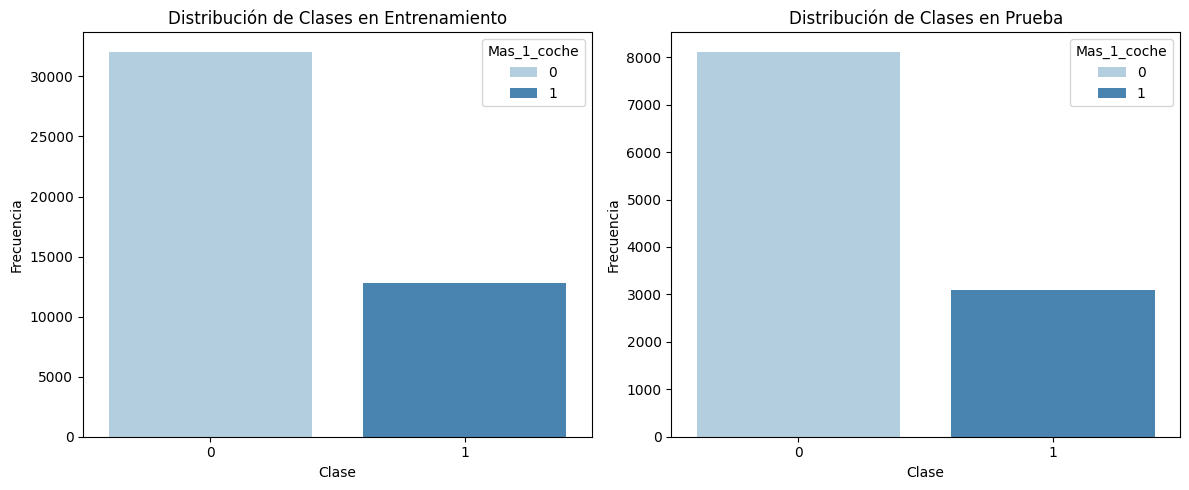

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribuci√≥n en el conjunto de entrenamiento.
sns.countplot(x=y_train, ax=axes[0], palette='Blues' , hue=y_train)
axes[0].set_title("Distribuci√≥n de Clases en Entrenamiento")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Frecuencia")
# Distribuci√≥n en el conjunto de prueba.
sns.countplot(x=y_test, ax=axes[1], palette='Blues', hue=y_test)
axes[1].set_title("Distribuci√≥n de Clases en Prueba")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Dado el objetivo del proyecto de predecir la **propensi√≥n de compra de un segundo veh√≠culo**, nos enfocaremos en la m√©trica de **Recall** para evaluar el rendimiento de nuestros modelos de clasificaci√≥n.

El conjunto de datos presenta un **desequilibrio de clases**, con una mayor proporci√≥n de clientes que **no compran un segundo veh√≠culo** en comparaci√≥n con aquellos que s√≠ lo hacen. En este contexto, la m√©trica de **Accuracy** podr√≠a ser enga√±osa, ya que un modelo que simplemente predice la clase mayoritaria (sin identificar correctamente a los compradores potenciales) puede obtener una alta precisi√≥n sin ser realmente √∫til.

**Importancia del Recall en el Contexto del Negocio.** El objetivo principal del modelo es **optimizar las campa√±as de marketing**, identificando clientes con **alta probabilidad de recompra**. Un alto **Recall** significa que estamos capturando correctamente a estos clientes, lo que permite a la empresa **dirigir sus esfuerzos de marketing de manera m√°s eficiente** y **reducir costos operativos**.

- **Recall alto** ‚Üí Mayor cantidad de clientes interesados correctamente identificados.
- **Recall bajo** ‚Üí Oportunidades de venta perdidas debido a predicciones err√≥neas.

Seg√∫n el **Project Charter**, uno de los principales problemas a resolver es la **falta de segmentaci√≥n efectiva**, lo que lleva a una inversi√≥n ineficiente en campa√±as publicitarias. Un modelo con alto **Recall** contribuir√° a la mejora de la tasa de conversi√≥n, ya que permitir√° identificar a los clientes m√°s propensos a comprar, aline√°ndose con los objetivos estrat√©gicos del negocio:
- **Mejor segmentaci√≥n** de clientes para campa√±as personalizadas.
- **Reducci√≥n del costo de adquisici√≥n de clientes** mediante campa√±as m√°s dirigidas.
- **Mayor fidelizaci√≥n de clientes** al enfocarse en usuarios con alta probabilidad de recompra.

Por lo tanto, en la evaluaci√≥n de modelos nos centraremos en **maximizar el Recall sin sacrificar excesivamente otras m√©tricas como la precisi√≥n y el AUC-ROC**, para garantizar una implementaci√≥n efectiva en el negocio.

## **Modelado con Random Forest.**
El modelo de Random Forest es un algoritmo de aprendizaje supervisado basado en el ensamblado de m√∫ltiples √°rboles de decisi√≥n. Su principal ventaja radica en su capacidad para reducir el sobreajuste y mejorar la precisi√≥n general del modelo mediante la combinaci√≥n de predicciones de varios √°rboles.

- Construye m√∫ltiples √°rboles de decisi√≥n y combina sus predicciones para mejorar la estabilidad y precisi√≥n del modelo.
- Reduce el sobreajuste en comparaci√≥n con los √°rboles de decisi√≥n individuales.
- Puede manejar datos con valores faltantes y escalar bien en conjuntos de datos grandes.

Permite la interpretaci√≥n de la importancia de las variables, ayudando a identificar las caracter√≠sticas m√°s relevantes en la predicci√≥n.

#### **Entrenamiento.**

In [206]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

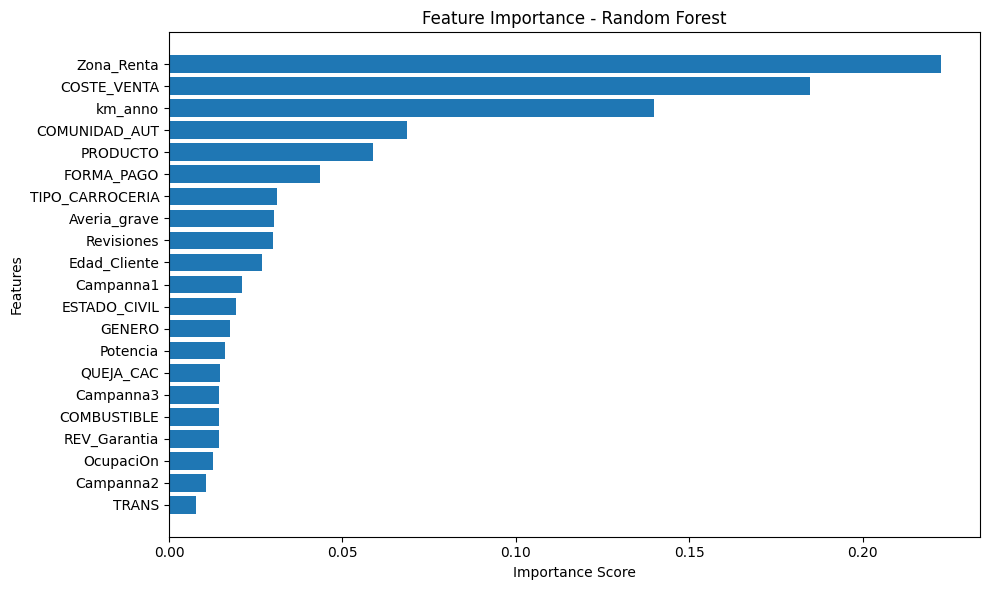

In [207]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [208]:
importance_df.tail(3)

Feature  Importance
8   OcupaciOn    0.012673
10  Campanna2    0.010689
4       TRANS    0.007850

La gr√°fica muestra la importancia relativa de cada variable en el modelo **Random Forest** para predecir la propensi√≥n de compra de un segundo coche. Se pueden extraer varias observaciones clave:

**Variables m√°s influyentes.**
   - **Zona_Renta:** La variable con mayor peso en la predicci√≥n, lo que sugiere que el nivel de renta de la zona donde reside el cliente influye significativamente en la decisi√≥n de compra.
   - **Coste de Venta:** Representa la suma de descuentos aplicados en la venta del veh√≠culo, lo que indica que el precio final despu√©s de descuentos tiene un impacto significativo en la decisi√≥n de compra.
   - **KM A√±o:** El kilometraje anual promedio tambi√©n resulta clave, probablemente reflejando el uso del veh√≠culo y la necesidad de renovaci√≥n.
   - **Comunidad aut√≥noma y Producto:** Factores geogr√°ficos y el tipo de producto parecen influir de manera notable en la propensi√≥n de compra.

**Variables con menor impacto.**
   - Variables como **REV Garantia, Ocupaci√≥n y Campa√±a 2** tienen una baja contribuci√≥n al modelo, lo que sugiere que su impacto en la decisi√≥n de compra es m√≠nimo.
   - **La variable TRANS tiene la menor importancia y, por lo tanto, se puede descartar en futuras iteraciones del modelo** para optimizar su rendimiento sin p√©rdida significativa de informaci√≥n.

El an√°lisis revela que las **variables econ√≥micas y geogr√°ficas** son los principales factores que afectan la decisi√≥n de compra de un segundo veh√≠culo. **La variable TRANS ser√° descartada en iteraciones futuras debido a su baja contribuci√≥n**, y se evaluar√° la necesidad de incluir otras transformaciones de datos para mejorar el modelo. **En la siguiente fase de optimizaci√≥n de hiperpar√°metros**, se evaluar√° si ajustar la profundidad de los √°rboles o el n√∫mero de estimadores mejora la capacidad predictiva del modelo.

### **Evaluaci√≥n.**

In [209]:
print("Train set score (Accuracy) =", rf_model.score(X_train, y_train))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.998573243863834
Test set score (Accuracy) = 0.8603655818100758
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7455 ‚îÇ            663 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ            903 ‚îÇ           2194 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90   

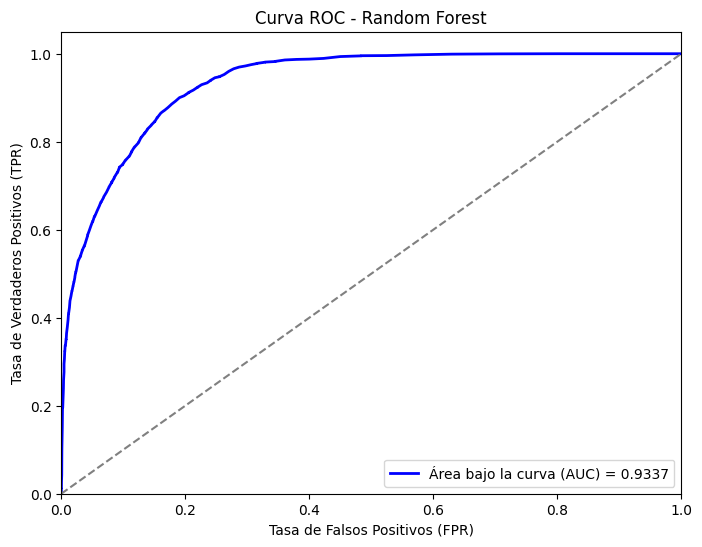

In [210]:
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase 1.

# C√°lculo de la Curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficaci√≥n de la Curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'√Årea bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # L√≠nea base.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [211]:
results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, rf_model.predict(X_test))],
    'Precision': [precision_score(y_test, rf_model.predict(X_test))],
    'Recall': [recall_score(y_test, rf_model.predict(X_test))],
    'F1': [f1_score(y_test, rf_model.predict(X_test))],
    'AUC': [roc_auc]
})
results.head()

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0  Random Forest     0.5  0.860366   0.767938  0.708428  0.736984  0.933726

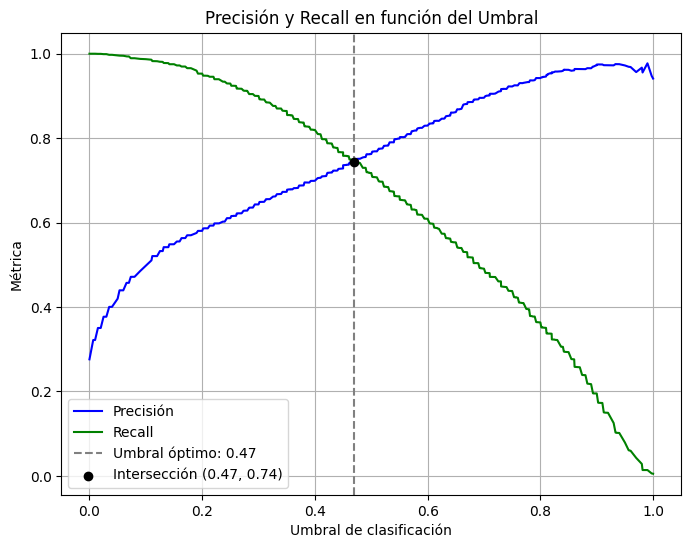

In [212]:
# Obtener probabilidades del modelo.
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersecci√≥n entre precisi√≥n y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisi√≥n", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral √≥ptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersecci√≥n ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificaci√≥n")
plt.ylabel("M√©trica")
plt.grid(True)
plt.legend()
plt.title("Precisi√≥n y Recall en funci√≥n del Umbral")
plt.show()

In [213]:
# Ajuste de umbral.
nuevo_umbral = 0.47
y_pred_new = (y_scores >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, rf_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusi√≥n con el nuevo umbral.
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.998573243863834
Test set score (Accuracy) = 0.8587605884975479
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7314 ‚îÇ            804 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ            780 ‚îÇ           2317 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90   

In [214]:
new_results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_scores)]
})

results = pd.concat([results, new_results], ignore_index=True)
results.head()

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0  Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1  Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726

El modelo de **Random Forest** ha demostrado un rendimiento s√≥lido en la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo, aline√°ndose con los objetivos clave del **Project Charter**. Con una alta precisi√≥n y un AUC destacado, el modelo es capaz de identificar de manera efectiva a los clientes con mayor probabilidad de realizar una recompra, lo que permitir√° optimizar las estrategias de marketing y ventas.

La capacidad del modelo para equilibrar **precisi√≥n** y **recall** es particularmente importante, ya que no solo busca predecir correctamente a los clientes propensos a comprar, sino tambi√©n minimizar los falsos positivos. Esto es crucial para reducir costos operativos y maximizar el retorno de las campa√±as dirigidas. Adem√°s, el ajuste del umbral de clasificaci√≥n ha permitido mejorar el **recall**, lo que significa que el modelo es m√°s efectivo para capturar a los clientes que realmente tienen una alta probabilidad de recompra.

## **Modelado con XGBoost.**

### **Entrenamiento.**

In [215]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

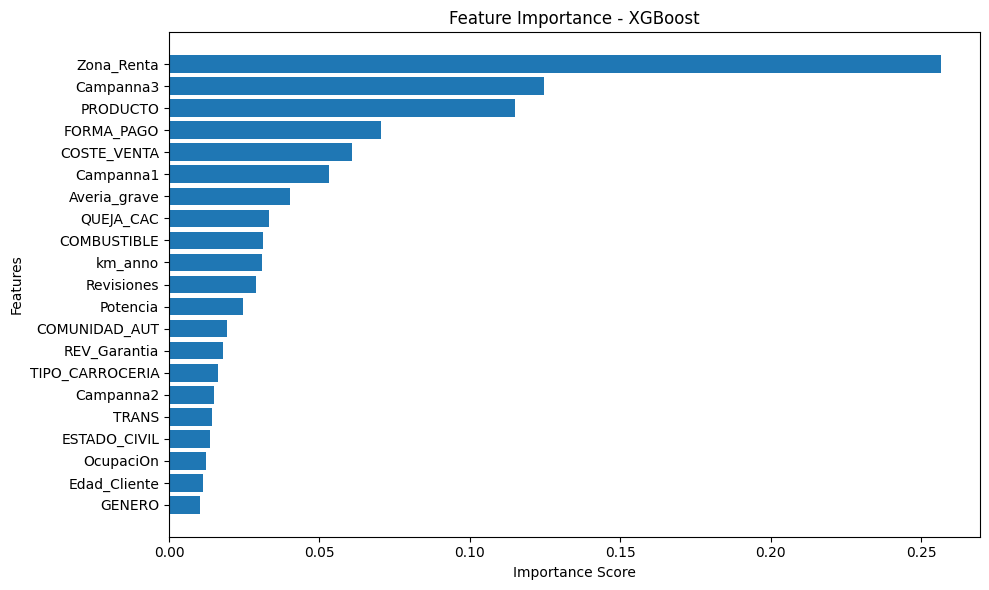

In [216]:
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

In [217]:
importance_df.tail(3)

Feature  Importance
8      OcupaciOn    0.012261
19  Edad_Cliente    0.011203
7         GENERO    0.010273

En la evaluaci√≥n de importancia de caracter√≠sticas obtenida con el modelo **XGBoost**, observamos que algunas variables tienen valores relativamente bajos de importancia en comparaci√≥n con otras. Sin embargo, ninguna de estas variables ser√° eliminada, ya que pueden aportar informaci√≥n relevante en la interacci√≥n con otras caracter√≠sticas.

### **Evaluaci√≥n.**

In [218]:
print("Train set score (Accuracy) =", accuracy_score(y_train, xgb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, xgb_model.predict(X_test)))

# Matriz de confusi√≥n
conf_mat = confusion_matrix(y_test, xgb_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, xgb_model.predict(X_test)))

Train set score (Accuracy) = 0.9190315892725773
Test set score (Accuracy) = 0.8715113687026304
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7474 ‚îÇ            644 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ            797 ‚îÇ           2300 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91  

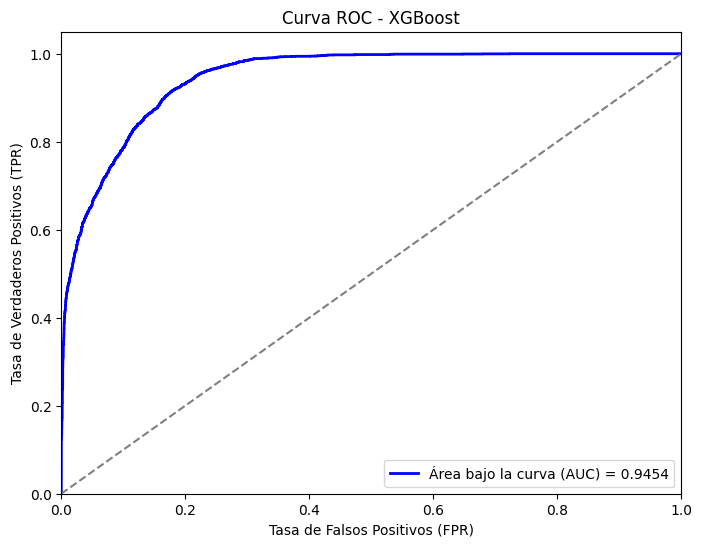

In [219]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'√Årea bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [220]:
new_results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, xgb_model.predict(X_test))],
    'Precision': [precision_score(y_test, xgb_model.predict(X_test))],
    'Recall': [recall_score(y_test, xgb_model.predict(X_test))],
    'F1': [f1_score(y_test, xgb_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
results.head()

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0  Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1  Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2        XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399

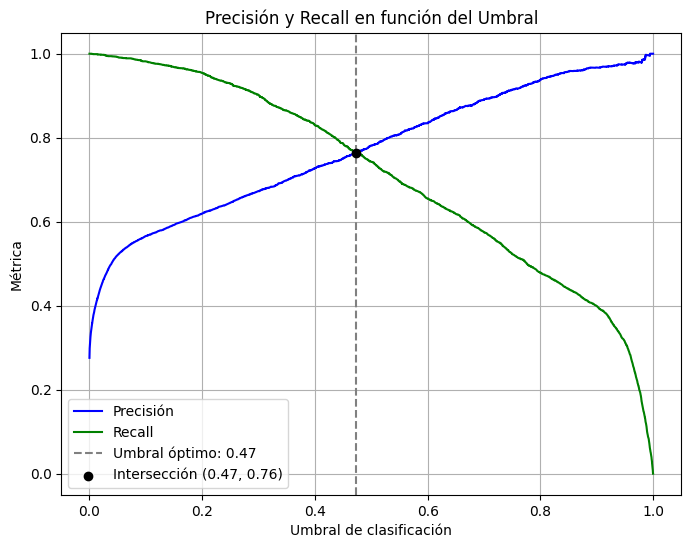

In [221]:
# Obtener probabilidades del modelo.
y_scores = xgb_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersecci√≥n entre precisi√≥n y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisi√≥n", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral √≥ptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersecci√≥n ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificaci√≥n")
plt.ylabel("M√©trica")
plt.grid(True)
plt.legend()
plt.title("Precisi√≥n y Recall en funci√≥n del Umbral")
plt.show()

In [222]:
nuevo_umbral = 0.47
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, xgb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusi√≥n con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.9190315892725773
Test set score (Accuracy) = 0.8696388765046812
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7377 ‚îÇ            741 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ            721 ‚îÇ           2376 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91  

In [223]:
new_results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
results.head()

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0  Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1  Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2        XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3        XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399

El modelo **XGBoost** ha mostrado un rendimiento excepcional en la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo, cumpliendo con los objetivos establecidos en el **Project Charter**. Con una precisi√≥n y un AUC a√∫n m√°s altos que los del modelo anterior, **XGBoost** demuestra una capacidad superior para identificar a los clientes con mayor probabilidad de realizar una recompra. Esto es fundamental para optimizar las estrategias de marketing y ventas, ya que permite enfocar los recursos en los clientes m√°s propensos a comprar, maximizando as√≠ el retorno de las campa√±as.

El ajuste del umbral de clasificaci√≥n ha permitido mejorar el **recall**, lo que significa que el modelo es m√°s efectivo para capturar a los clientes que realmente tienen una alta probabilidad de recompra, sin sacrificar significativamente la precisi√≥n. Este equilibrio entre **precisi√≥n** y **recall** es clave para garantizar que las campa√±as sean tanto efectivas como eficientes, reduciendo costos operativos y mejorando la rentabilidad.

## **Modelado con Gradient Boosting.**

### **Entrenamiento.**

In [224]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

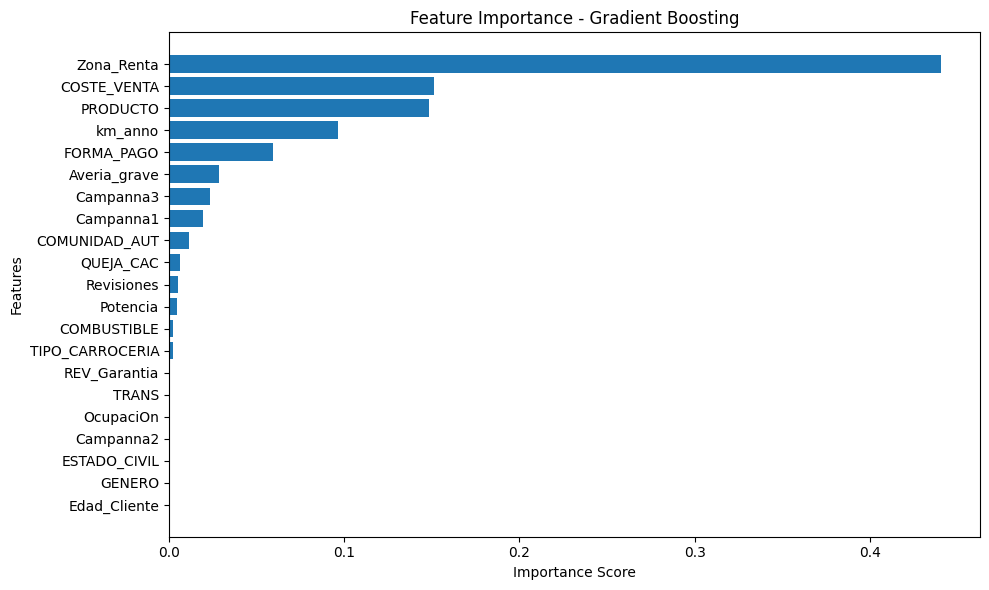

In [225]:
feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

In [226]:
importance_df.tail(8)

Feature  Importance
1   TIPO_CARROCERIA    0.002085
13     REV_Garantia    0.000232
4             TRANS    0.000000
8         OcupaciOn    0.000000
10        Campanna2    0.000000
6      ESTADO_CIVIL    0.000000
7            GENERO    0.000000
19     Edad_Cliente    0.000000

En la evaluaci√≥n de importancia de caracter√≠sticas obtenida con el modelo **Gradient Boosting**, observamos que algunas variables tienen importancia extremadamente baja o nula. En este caso, se puede considerar la eliminaci√≥n de ciertas variables para mejorar la eficiencia del modelo sin afectar su rendimiento.

Las variables con importancia de caracter√≠sticas nula pueden ser eliminadas, no tienen contribuci√≥n al modelo. A su vez, se podr√≠a eliminar tambi√©n la columna **REV Garantia** por tener un impacto insignificante.

### **Evaluaci√≥n.**

In [227]:
# Evaluaci√≥n del modelo
print("Train set score (Accuracy) =", accuracy_score(y_train, gb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, gb_model.predict(X_test)))

# Matriz de confusi√≥n
conf_mat = confusion_matrix(y_test, gb_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, gb_model.predict(X_test)))

Train set score (Accuracy) = 0.8438816684129568
Test set score (Accuracy) = 0.8430673205528311
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7408 ‚îÇ            710 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ           1050 ‚îÇ           2047 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89  

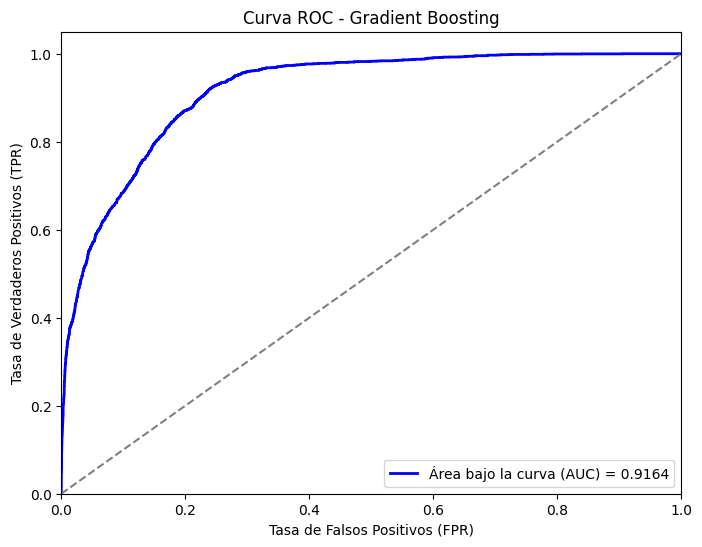

In [228]:
y_probs = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'√Årea bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

In [229]:
new_results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, gb_model.predict(X_test))],
    'Precision': [precision_score(y_test, gb_model.predict(X_test))],
    'Recall': [recall_score(y_test, gb_model.predict(X_test))],
    'F1': [f1_score(y_test, gb_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
results.head()

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0      Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1      Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2            XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3            XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399
4  Gradient Boosting    0.50  0.843067   0.742474  0.660962  0.699351  0.916391

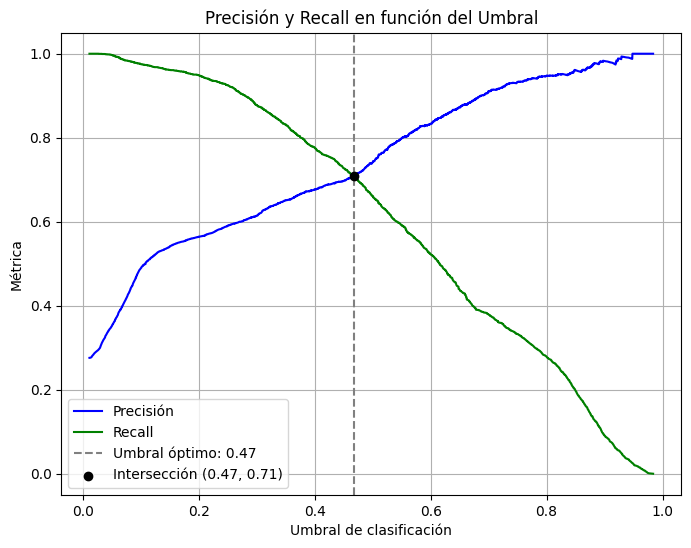

In [230]:
# Obtener probabilidades del modelo.
y_scores = gb_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersecci√≥n entre precisi√≥n y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisi√≥n", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral √≥ptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersecci√≥n ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificaci√≥n")
plt.ylabel("M√©trica")
plt.grid(True)
plt.legend()
plt.title("Precisi√≥n y Recall en funci√≥n del Umbral")
plt.show()

In [231]:
nuevo_umbral = 0.47
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, gb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusi√≥n con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.8438816684129568
Test set score (Accuracy) = 0.8391440035666518
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7228 ‚îÇ            890 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ            914 ‚îÇ           2183 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89  

In [232]:
new_results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
display(results)

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0      Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1      Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2            XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3            XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399
4  Gradient Boosting    0.50  0.843067   0.742474  0.660962  0.699351  0.916391
5  Gradient Boosting    0.47  0.839144   0.710381  0.704876  0.707618  0.916391

El modelo **Gradient Boosting** ha mostrado un rendimiento adecuado en la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo, aunque con una precisi√≥n y AUC inferiores a los de otros modelos evaluados. A pesar de su estabilidad y capacidad para manejar datos complejos, su desempe√±o indica que no es la opci√≥n m√°s eficiente para identificar clientes con alta probabilidad de recompra en este caso.

El ajuste del umbral ha permitido mejorar ligeramente el **recall**, lo que implica que el modelo es m√°s eficaz en la detecci√≥n de clientes que realmente comprar√°n un segundo coche. Sin embargo, esta mejora en **recall** no se traduce en un aumento significativo del **F1-score**, lo que sugiere que el modelo no logra un equilibrio √≥ptimo entre capturar clientes potenciales y evitar falsos positivos.

Dado el rendimiento observado, **Gradient Boosting** puede no ser la mejor opci√≥n para este problema espec√≠fico, especialmente si se busca maximizar la efectividad de las campa√±as de marketing y ventas. En comparaci√≥n con otros modelos como **XGBoost** y **Random Forest**, su capacidad predictiva es inferior, lo que sugiere que su uso deber√≠a reconsiderarse o que requerir√≠a ajustes adicionales en sus hiperpar√°metros para mejorar su desempe√±o.

## **Modelado con AdaBoost.**

### **Entrenamiento.**

In [233]:
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

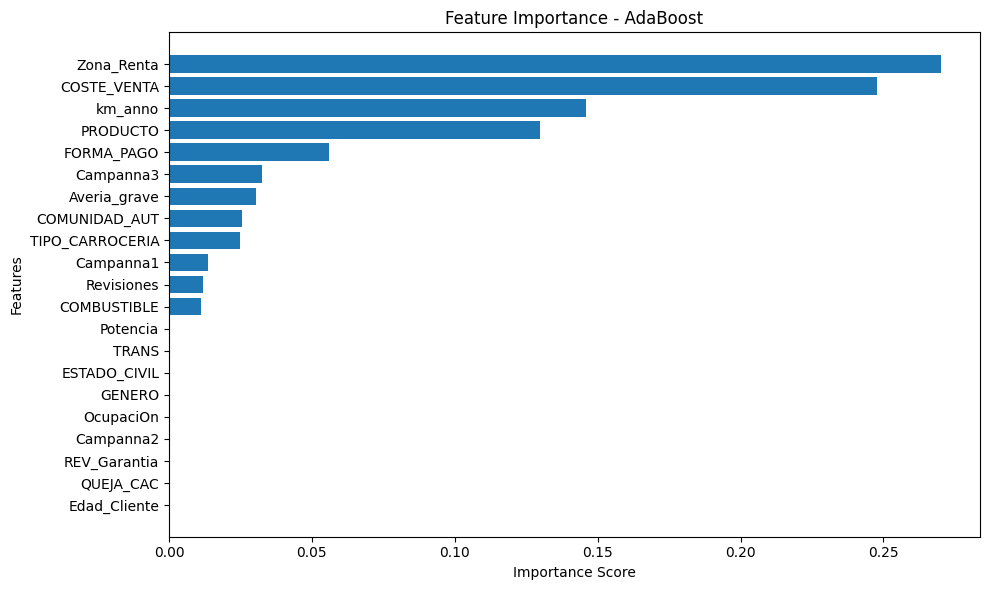

In [234]:
feature_importances = ab_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - AdaBoost')
plt.tight_layout()
plt.show()

In [235]:
importance_df.tail(10)

Feature  Importance
2    COMBUSTIBLE    0.011317
3       Potencia    0.000000
4          TRANS    0.000000
6   ESTADO_CIVIL    0.000000
7         GENERO    0.000000
8      OcupaciOn    0.000000
10     Campanna2    0.000000
13  REV_Garantia    0.000000
15     QUEJA_CAC    0.000000
19  Edad_Cliente    0.000000

En la evaluaci√≥n de importancia de caracter√≠sticas obtenida con el modelo **AdaBoost**, observamos que varias variables presentan una importancia extremadamente baja o nula. Esto sugiere que no est√°n contribuyendo de manera significativa a las predicciones y podr√≠an eliminarse para optimizar el modelo.

Las variables con importancia de caracter√≠sticas nula pueden ser eliminada, no tienen contribuci√≥n al modelo.

### **Evaluaci√≥n.**

In [236]:
print("Train set score (Accuracy) =", accuracy_score(y_train, ab_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, ab_model.predict(X_test)))

# Matriz de confusi√≥n
conf_mat = confusion_matrix(y_test, ab_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, ab_model.predict(X_test)))

Train set score (Accuracy) = 0.8007445883585617
Test set score (Accuracy) = 0.8032991529201962
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           7353 ‚îÇ            765 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ           1441 ‚îÇ           1656 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87  

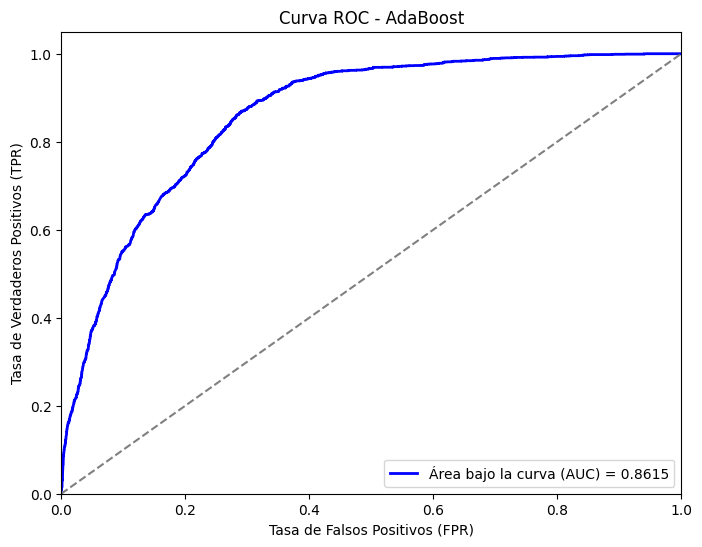

In [237]:
y_probs = ab_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'√Årea bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc="lower right")
plt.show()

In [238]:
new_results = pd.DataFrame({
    'Model': ['AdaBoost'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, ab_model.predict(X_test))],
    'Precision': [precision_score(y_test, ab_model.predict(X_test))],
    'Recall': [recall_score(y_test, ab_model.predict(X_test))],
    'F1': [f1_score(y_test, ab_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
display(results)

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0      Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1      Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2            XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3            XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399
4  Gradient Boosting    0.50  0.843067   0.742474  0.660962  0.699351  0.916391
5  Gradient Boosting    0.47  0.839144   0.710381  0.704876  0.707618  0.916391
6           AdaBoost    0.50  0.803299   0.684015  0.534711  0.600217  0.861495

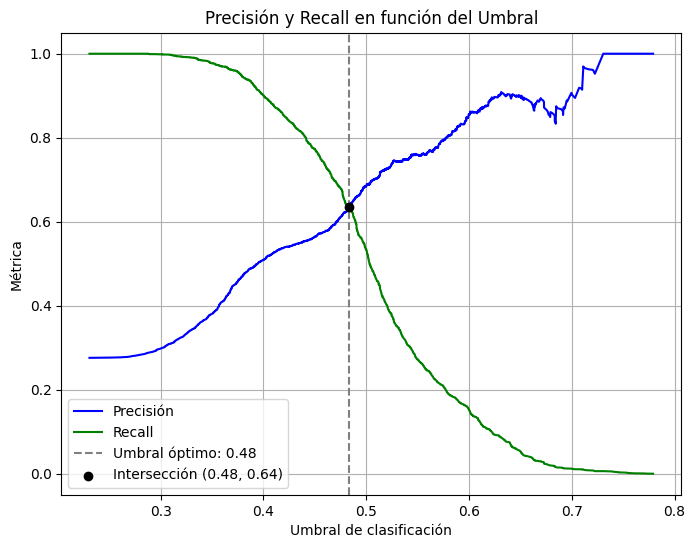

In [239]:
# Obtener probabilidades del modelo.
y_scores = ab_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersecci√≥n entre precisi√≥n y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisi√≥n", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral √≥ptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersecci√≥n ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificaci√≥n")
plt.ylabel("M√©trica")
plt.grid(True)
plt.legend()
plt.title("Precisi√≥n y Recall en funci√≥n del Umbral")
plt.show()

In [240]:
nuevo_umbral = 0.48
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, ab_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusi√≥n con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.8007445883585617
Test set score (Accuracy) = 0.7938475256353098
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ              ‚îÇ   Pred Class 0 ‚îÇ   Pred Class 1 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Real Class 0 ‚îÇ           6912 ‚îÇ           1206 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Real Class 1 ‚îÇ           1106 ‚îÇ           1991 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86  

In [241]:
new_results = pd.DataFrame({
    'Model': ['AdaBoost'],
    'Umbral': [0.48],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
display(results)

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0      Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1      Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2            XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3            XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399
4  Gradient Boosting    0.50  0.843067   0.742474  0.660962  0.699351  0.916391
5  Gradient Boosting    0.47  0.839144   0.710381  0.704876  0.707618  0.916391
6           AdaBoost    0.50  0.803299   0.684015  0.534711  0.600217  0.861495
7           AdaBoost    0.48  0.793848   0.622771  0.642880  0.632666  0.861495

El modelo **AdaBoost** ha mostrado un desempe√±o limitado en la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo, con una precisi√≥n y AUC inferiores a las de otros modelos evaluados. Si bien su naturaleza basada en combinaciones secuenciales de clasificadores d√©biles le otorga robustez ante datos ruidosos, su rendimiento sugiere que no es la opci√≥n m√°s efectiva para este caso espec√≠fico.

El ajuste del umbral ha permitido mejorar el **recall**, lo que indica una mayor capacidad para identificar a los clientes con potencial de recompra. Sin embargo, esta mejora no se traduce en un equilibrio adecuado con la **precisi√≥n**, lo que podr√≠a derivar en un incremento de falsos positivos y, por ende, en una asignaci√≥n ineficiente de recursos en las estrategias de marketing y ventas.

Dado su rendimiento, **AdaBoost** parece ser menos competitivo en comparaci√≥n con **XGBoost, Random Forest y Gradient Boosting**, lo que sugiere que su uso deber√≠a reconsiderarse. Si se opta por seguir explor√°ndolo, ser√≠a recomendable realizar un ajuste m√°s profundo de sus hiperpar√°metros para evaluar posibles mejoras en su capacidad predictiva.

## **Comparaci√≥n de Modelos.**

### **Evaluaci√≥n de m√©tricas.**

En la evaluaci√≥n de distintos modelos para predecir la **propensi√≥n de compra de un segundo veh√≠culo**, los resultados indican que **XGBoost** y **Random Forest** son las opciones m√°s s√≥lidas, mientras que **Gradient Boosting** y **AdaBoost** presentan un desempe√±o inferior en este caso espec√≠fico.

El modelo **XGBoost** se destaca como la mejor opci√≥n, logrando una combinaci√≥n √≥ptima entre **precisi√≥n y recall**, lo que permite identificar con gran eficacia a los clientes con mayor probabilidad de recompra. Su alto **AUC** confirma su capacidad para discriminar correctamente entre compradores y no compradores, lo que lo convierte en una herramienta clave para **optimizar las estrategias de marketing y ventas**.

**Random Forest** tambi√©n muestra un rendimiento s√≥lido, con una alta precisi√≥n y un buen balance entre **recall** y **precisi√≥n**. Su desempe√±o es competitivo frente a XGBoost y puede ser una alternativa viable si se busca un modelo robusto y menos complejo computacionalmente.

Por otro lado, **Gradient Boosting**, aunque estable, tiene una menor capacidad predictiva en comparaci√≥n con XGBoost y Random Forest. Su menor **precisi√≥n y recall** sugieren que no logra un equilibrio √≥ptimo entre la captura de clientes potenciales y la reducci√≥n de falsos positivos. Si bien puede mejorar con ajuste de hiperpar√°metros, no parece ser la opci√≥n m√°s eficiente en su configuraci√≥n actual.

Finalmente, **AdaBoost** es el modelo con el rendimiento m√°s limitado, mostrando dificultades para identificar correctamente a los clientes con alta probabilidad de recompra. Su menor **AUC** y la falta de equilibrio en sus m√©tricas hacen que su aplicaci√≥n en este caso sea menos recomendable.

In [242]:
display(results)

Model  Umbral  Accuracy  Precision    Recall        F1       AUC
0      Random Forest    0.50  0.860366   0.767938  0.708428  0.736984  0.933726
1      Random Forest    0.47  0.858761   0.742390  0.748143  0.745256  0.933726
2            XGBoost    0.50  0.871511   0.781250  0.742654  0.761463  0.945399
3            XGBoost    0.47  0.869639   0.762271  0.767194  0.764725  0.945399
4  Gradient Boosting    0.50  0.843067   0.742474  0.660962  0.699351  0.916391
5  Gradient Boosting    0.47  0.839144   0.710381  0.704876  0.707618  0.916391
6           AdaBoost    0.50  0.803299   0.684015  0.534711  0.600217  0.861495
7           AdaBoost    0.48  0.793848   0.622771  0.642880  0.632666  0.861495

**Conclusi√≥n General:** El modelo **XGBoost** es la mejor alternativa para la predicci√≥n de recompra, seguido de cerca por **Random Forest**. Ambos modelos cumplen con los objetivos establecidos en el **Project Charter**, permitiendo una mejor segmentaci√≥n de clientes y una asignaci√≥n m√°s eficiente de recursos en campa√±as de marketing. **Gradient Boosting y AdaBoost**, en su configuraci√≥n actual, no ofrecen un rendimiento competitivo y podr√≠an requerir un ajuste m√°s profundo de hiperpar√°metros si se considerara su implementaci√≥n.

#### **Matrices de confusi√≥n.**

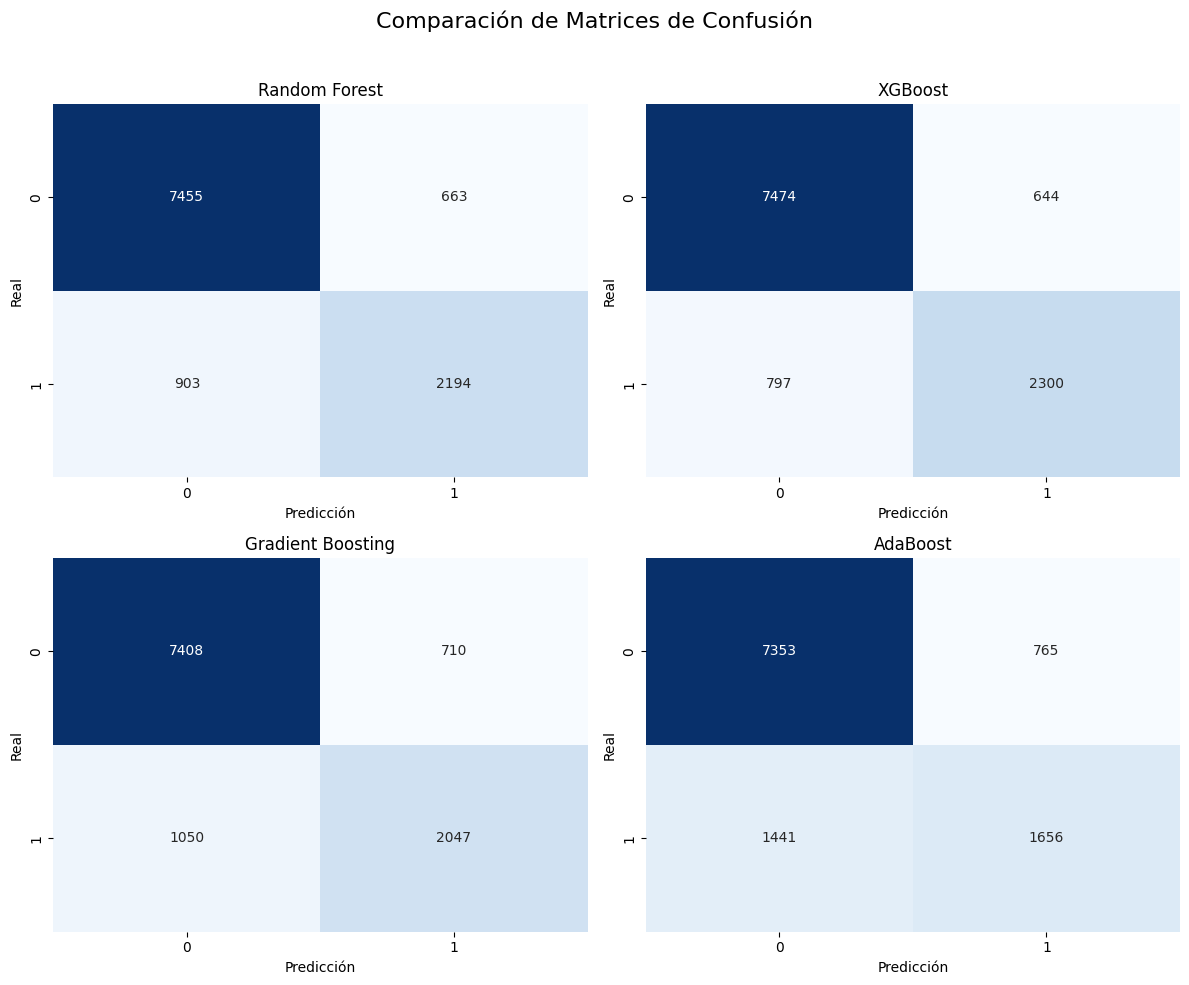

In [243]:
# Obtenci√≥n de matrices de confusi√≥n para cada modelo.
conf_matrix_rf = confusion_matrix(y_test, rf_model.predict(X_test))
conf_matrix_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))
conf_matrix_gb = confusion_matrix(y_test, gb_model.predict(X_test))
conf_matrix_ab = confusion_matrix(y_test, ab_model.predict(X_test))

# Creaci√≥n de subplots para visualizar las matrices de confusi√≥n.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparaci√≥n de Matrices de Confusi√≥n", fontsize=16)

# Modelos.
models = ["Random Forest", "XGBoost", "Gradient Boosting", "AdaBoost"]
conf_matrices = [conf_matrix_rf, conf_matrix_xgb, conf_matrix_gb, conf_matrix_ab]
ax_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Gr√°ficos.
for ax, model, matrix, pos in zip(axes.flat, models, conf_matrices, ax_positions):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(model)
    ax.set_xlabel("Predicci√≥n")
    ax.set_ylabel("Real")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### **Feature Importance.**

In [244]:
# Creaci√≥n de un DataFrame con la importancia de caracter√≠sticas de cada modelo base.
rf_importance = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': rf_model.feature_importances_})
xgb_importance = pd.DataFrame({'Feature': X_train.columns, 'XGBoost': xgb_model.feature_importances_})
gb_importance = pd.DataFrame({'Feature': X_train.columns, 'GradientBoosting': gb_model.feature_importances_})
ab_importance = pd.DataFrame({'Feature': X_train.columns, 'AdaBoost': ab_model.feature_importances_})

feature_importance_df = rf_importance.merge(xgb_importance, on="Feature") \
                                     .merge(gb_importance, on="Feature") \
                                     .merge(ab_importance, on="Feature")

feature_importance_df.head()

Feature  RandomForest   XGBoost  GradientBoosting  AdaBoost
0         PRODUCTO      0.058922  0.115129          0.148452  0.129938
1  TIPO_CARROCERIA      0.031090  0.016346          0.002085  0.024761
2      COMBUSTIBLE      0.014333  0.031110          0.002469  0.011317
3         Potencia      0.016183  0.024480          0.004510  0.000000
4            TRANS      0.007850  0.014153          0.000000  0.000000

In [245]:
feature_importance_df.to_csv("../benchmarking/baseline_models/feature_importance.csv", index=False)

### **Evaluaci√≥n de curvas ROC.**

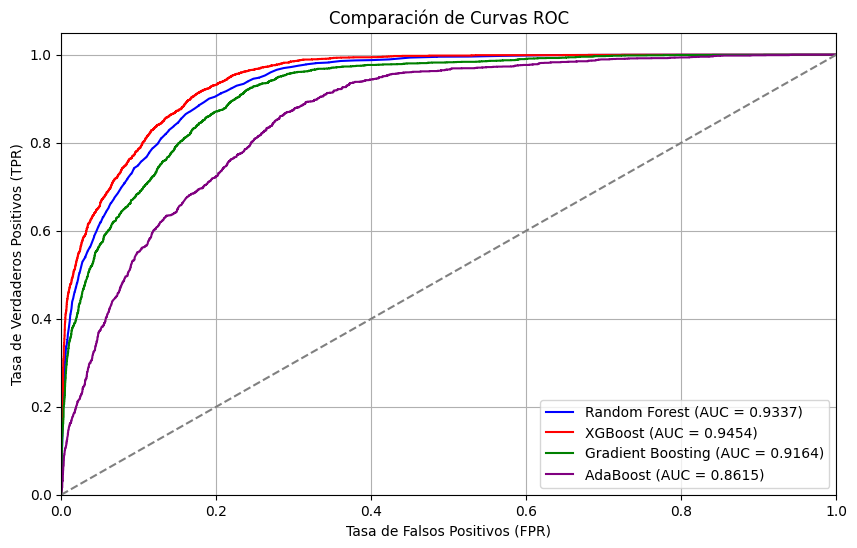

In [246]:
# C√°lculo de las curvas ROC para cada modelo.
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_model.predict_proba(X_test)[:, 1])
roc_auc_ab = auc(fpr_ab, tpr_ab)

# Gr√°fico de las curvas ROC.
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', color='red')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', color='green')
plt.plot(fpr_ab, tpr_ab, label=f'AdaBoost (AUC = {roc_auc_ab:.4f})', color='purple')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # L√≠nea base.

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparaci√≥n de Curvas ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

La comparaci√≥n de las curvas **ROC** confirma que el modelo **XGBoost** es el m√°s eficiente en la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo, logrando la mejor capacidad para diferenciar entre clientes que recomprar√°n y aquellos que no. Su desempe√±o lo convierte en la opci√≥n m√°s s√≥lida para optimizar estrategias de marketing y ventas.

El modelo **Random Forest** tambi√©n ofrece un rendimiento altamente competitivo, con un comportamiento muy cercano al de XGBoost. Su robustez y facilidad de interpretaci√≥n lo hacen una alternativa viable, especialmente si se busca una opci√≥n m√°s estable y menos exigente en t√©rminos computacionales.

Por otro lado, **Gradient Boosting** muestra una capacidad predictiva aceptable, aunque inferior a XGBoost y Random Forest. Si bien puede ser √∫til en algunos escenarios, no alcanza el mismo nivel de precisi√≥n y discriminaci√≥n, lo que podr√≠a traducirse en un menor impacto en la toma de decisiones estrat√©gicas.

Finalmente, **AdaBoost** presenta el rendimiento m√°s bajo de todos los modelos evaluados. Su menor capacidad para distinguir entre clientes potenciales y no compradores sugiere que no es la mejor opci√≥n para este caso de uso, ya que podr√≠a generar m√°s errores en la segmentaci√≥n de clientes.

**Conclusi√≥n General.**
- **XGBoost** es el modelo m√°s efectivo, con la mejor capacidad de clasificaci√≥n.
- **Random Forest** es una alternativa s√≥lida, con un rendimiento muy cercano.
- **Gradient Boosting** es una opci√≥n aceptable, pero menos eficiente en comparaci√≥n con los anteriores.
- **AdaBoost** no es recomendable para este caso, debido a su menor capacidad predictiva.

En base a estos resultados, se recomienda utilizar **XGBoost o Random Forest** para la predicci√≥n de la propensi√≥n de compra, garantizando una segmentaci√≥n m√°s precisa y un mejor aprovechamiento de los recursos en las campa√±as de marketing y ventas. üöÄ

### **Selecci√≥n de modelos.**

Tras la evaluaci√≥n de los modelos base, se ha determinado que **XGBoost y Random Forest** son las opciones m√°s prometedoras para la predicci√≥n de la propensi√≥n de compra de un segundo veh√≠culo. Ambos modelos han mostrado un **alto AUC y un equilibrio adecuado entre precisi√≥n y recall**, lo que los convierte en candidatos ideales para optimizar su desempe√±o mediante la **b√∫squeda de hiperpar√°metros**.

En el siguiente notebook, nos enfocaremos en **ajustar los hiperpar√°metros de XGBoost y Random Forest** para maximizar su rendimiento. Aunque Gradient Boosting ha mostrado un desempe√±o aceptable, su menor efectividad en comparaci√≥n con los otros dos modelos hace que no sea prioritario en esta fase de optimizaci√≥n. AdaBoost, debido a su bajo AUC y menor capacidad predictiva, ser√° descartado de la b√∫squeda de hiperpar√°metros.

In [247]:
results.to_csv('../benchmarking/baseline_models/baseline_models.csv', index=False)